# 0.0 Imports

In [1]:
#!pip install inflection
#!pip install pandas==0.25.3
#!pip install Boruta

In [87]:
import math
import pandas  as pd
import numpy   as np
import inflection
import random
import warnings
import seaborn as sns
import xgboost as xgb


from boruta                import BorutaPy
from tabulate              import tabulate
from datetime              import timedelta, datetime
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error,mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso



## 0.1. Helper Functions

In [3]:
# section function 7.2.1
def cross_validation(x_training,kfold, model_name, model, verbose=False):
  mae_list = []
  mape_list = []
  rmse_list = []
  
  for k in reversed(range(1, kfold+1)):
    if verbose:
      print('\nKfold Number: {}'.format(k))

    #start and end date for validation
    validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

    # filtering dataset
    t = x_training[x_training['date']< validation_start_date]
    v = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
    

    #training and validation

    #training
    xtraining = t.drop(['date','sales'],axis=1)
    ytraining = t['sales']

    #validation
    xvalidation = v.drop(['date','sales'],axis=1)
    yvalidation = v['sales']

    #model
    m = model.fit(xtraining, ytraining)

    #predict
    yhat = m.predict(xvalidation)

    #performace
    m_result= ml_error(model_name, np.expm1(yvalidation),np.expm1(yhat))
    
    # store performace of each Kfolds iteration

    mae_list.append(m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])

  return pd.DataFrame({'Model Name': model_name,
                       'MAE CV':  np.round(np.mean(mae_list),2).astype(str) + '+/-' +  np.round(np.std(mae_list),2).astype(str),
                       'MAPE CV':  np.round(np.mean(mape_list),2).astype(str) + '+/-' +  np.round(np.std(mape_list),2).astype(str),
                       'RMSE CV':  np.round(np.mean(rmse_list),2).astype(str) + '+/-' +  np.round(np.std(rmse_list),2).astype(str)},index=[0])

# section function 7.0
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

# section function 7.0
def ml_error(model_name,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# section function 4.1.3
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix() #cm confusion metrics  crosstab (Calcule uma tabulação cruzada simples de dois (ou mais) fatores)
    n = cm.sum()
    r, k = cm.shape  #número de linhas e colunas
    
    chi2 = ss.chi2_contingency( cm )[0]  #chi2 já tem método para calcular com scipy
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    
    %matplotlib inline 
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=[20,10]
    plt.rcParams['font.size']=10
    
    display( HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    #pd.set_options('display.expand_frame_repr',False )
    
    sns.set()
    

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2. Loading Data

In [88]:
warnings.filterwarnings ('ignore')

In [5]:
# o argumento low_memory fala para função pd.read para ler todo o arquivo de uma só vez

#df_sales_row = pd.read_csv('data/train.csv', low_memory=False)
#df_store_row = pd.read_csv('data/store.csv', low_memory=False)

# Carregar dados no google colab
df_sales_row = pd.read_csv('/content/train.csv', low_memory=False)
df_store_row = pd.read_csv('/content/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_row, df_store_row)#, how='left', on ='Store')

In [6]:
df_raw.sample(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
539078,591,4,2013-06-13,4339,454,1,0,0,0,a,c,3340.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


# 1.0 Data Description 

## 1.1. Rename Columns

In [7]:
df1 = df_raw.copy()

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval'] 

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#Rename of columns
df1.columns = cols_new

## 1.2. Data Dimension

In [10]:
print('Number rows: {}'.format(df1.shape[0]))
print('Number cols: {}'.format(df1.shape[1]))

Number rows: 1017209
Number cols: 18


In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

## 1.3. Data Types

In [12]:
df1['date'] = pd.to_datetime(df1['date'],errors='coerce')
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
#competition_distance 
# Ela vai mostrar se na coluna tem NA o "isnan"
# apply aplica a função em todas as linhas

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month

df1['competition_open_since_month']= df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 

df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                               
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

#promo2_since_year       

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval  
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map']= df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']== 0 else 1 if x['month_map']in x['promo_interval'].split(',') else 0 , axis=1)                 


In [16]:
df1.sample(5).T

,499901,280869,289858,320931,714684
store,549,310,319,353,785
day_of_week,5,1,6,3,2
date,2014-11-28 00:00:00,2015-04-27 00:00:00,2013-06-01 00:00:00,2014-07-09 00:00:00,2014-05-13 00:00:00
sales,6884,12204,6308,5460,4335
customers,728,925,705,1484,412
open,1,1,1,1,1
promo,1,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,b,d


## 1.6. Change

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

In [19]:
#Separar as variáveis numéricas das categóricas

num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes=df1.select_dtypes(include = ['object'])

### 1.7.1 Numerical Attributes

In [20]:
#Central tendencian - mean, median

ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


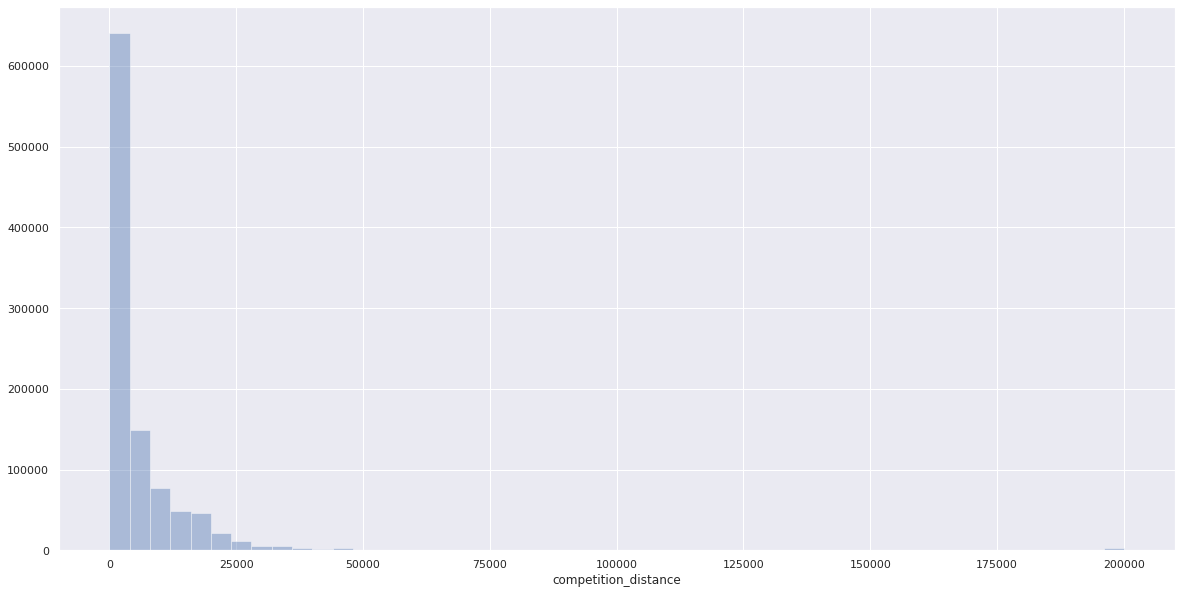

In [21]:
sns.distplot(df1['competition_distance'], kde= False)

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

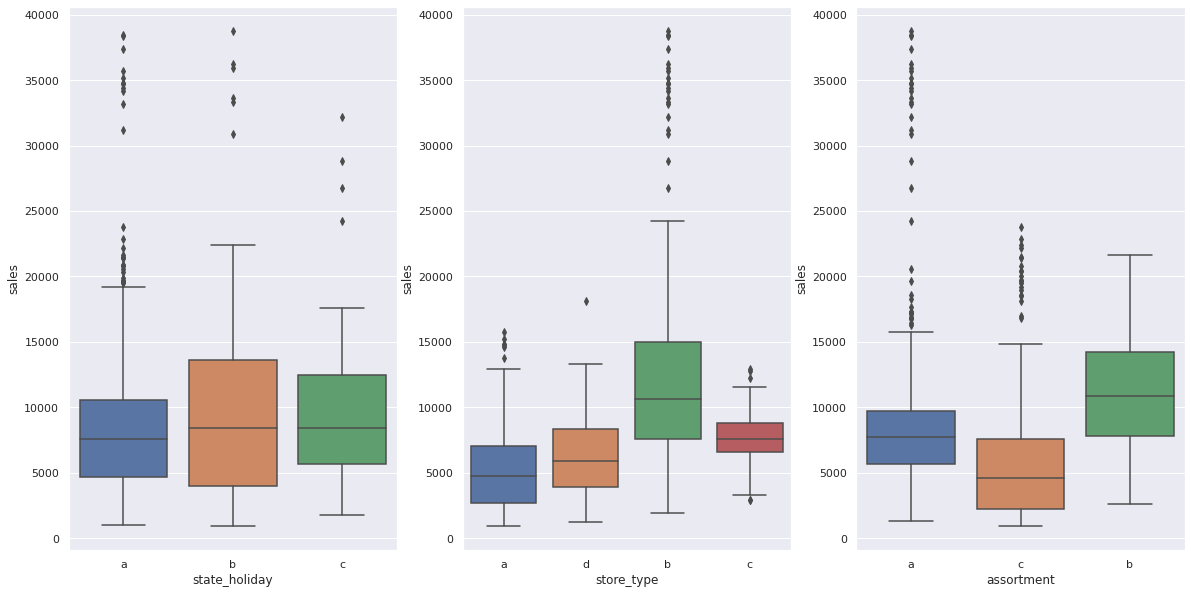

In [23]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0) ]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y= 'sales', data= aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y= 'sales', data= aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y= 'sales', data= aux)




##### Fenômeno
 
    - É aquilo que você está tentando medir ou modelar
    - Qual o fenômeno você está tentando modelar?

##### Agentes
    - Quem são os agentes atuam sobre o fenômeno de interesse?

##### Atributos dos agentes
    - Qual a descrição dos Agentes?

##### Lista  de Hipóteses:
    - Hipóteses para validar com os dados?

##### Como escrever hipóteses?

# 2.0 Feature Engineering

## 2.1  Mapa das Hipóteses

In [24]:
Image('img/MindMapHypothesis.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses das Lojas

**1-** Lojas com maior número de funcionários deveriam vender mais.

**2-** Lojas com maior capacidade de estoque deveriam vender mais.

**3-** Lojas com maior porte deveriam vender mais.

**4-** Lojas com competidores mais próximos deveriam vender menos.

**5-** Lojas com maior sortimento deveriam vender mais.

**6-** Lojas com competidores à mais tempo  deveriam vender mais.

### 2.2.2 Hipóteses dos Produtos

**1-** Lojas que investem mais em Marketing deveriam vender mais.

**2-** Lojas com maior exposição de produtos deveriam vender mais.

**3-** Lojas com produtos com preço menor deveriam vender mais.

**4-** Lojas com promoções mais agressivas(descontos maiores), deveriam vender mais.

**5-** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6-** Lojas com mais dias de promoção deveriam vender mais.

**7-** Lojas com mais promoções consecutivas deveriam vender mais.


### 2.2.3 Hipóteses de Tempo

**1-** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2-** Lojas deveriam vender mais ao longo dos anos

**3-** Lojas deveriam vender mais no segundo semestre do ano.

**4-** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5-** Lojas deveriam vender menos aos finais de semana.

**6-** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Hipóteses Finais

- Loja

**1-** Lojas com competidores mais próximos deveriam vender menos.

**2-** Lojas com maior sortimento deveriam vender mais.

**3-** Lojas com competidores à mais tempo  deveriam vender mais.

- Produtos

**4-** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5-** Lojas com mais dias de promoção deveriam vender mais.

**6-** Lojas com mais promoções consecutivas deveriam vender mais.

- Tempo

**7-** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8-** Lojas deveriam vender mais ao longo dos anos

**9-** Lojas deveriam vender mais no segundo semestre do ano.

**10-** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11-** Lojas deveriam vender menos aos finais de semana.

**12-** Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Engineering

In [25]:
df2 = df1.copy()

In [26]:
#year 
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')


#competition of since
df2['competition_since']= df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')- datetime.timedelta( days=7 ))
df2['promo_since_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] =df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x =='c' else 'regular_day')



In [27]:
df2.head().T

,0,1,2,3,4
store,1,1,1,1,1
day_of_week,5,4,3,2,1
date,2015-07-31 00:00:00,2015-07-30 00:00:00,2015-07-29 00:00:00,2015-07-28 00:00:00,2015-07-27 00:00:00
sales,5263,5020,4782,5011,6102
customers,555,546,523,560,612
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,c,c,c,c


# 3.0 Variable Filtering

##### Filtragem de variáveis
 - Restrições de Acordo com o Negócio

##### Seleção de Variáveis:
 - Variáveis mais relevantes para o modelo

In [28]:
df3 = df2.copy()

In [29]:
df3.head().T

,0,1,2,3,4
store,1,1,1,1,1
day_of_week,5,4,3,2,1
date,2015-07-31 00:00:00,2015-07-30 00:00:00,2015-07-29 00:00:00,2015-07-28 00:00:00,2015-07-27 00:00:00
sales,5263,5020,4782,5011,6102
customers,555,546,523,560,612
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,c,c,c,c


## 3.1 Rows Filtering

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selection Columns

In [31]:
col_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(col_drop, axis = 1)

In [32]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_since_week'],
      dtype='object')

# 4.0 Exploratory Analysis

##### Quais os 3 objetivos da EDA?
  - Ganhar experiência de Negócio
  - Validar Hipóteses dde Negócio. (Insights)
  - Perceber variáveis que são importantes para o modelo.
    
##### Tem 3 tipos de análise sendo elas:
   - Análise Univariada - Como é essa variável? ( Min, Max, Range, ...) 
   - Análise Bivariada - Como a variável impacta na resposta? (Correlação, validação das hpóteses ..)
   - Análise Multivariadas - Como as variáveis se relacionam? ( Qual a correlação entre elas)
    

In [33]:
df4 = df3.copy()

## 4.1 Analysis Univariate

### 4.1.1 Response Variable

### 4.1.2 Numerical Variable

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

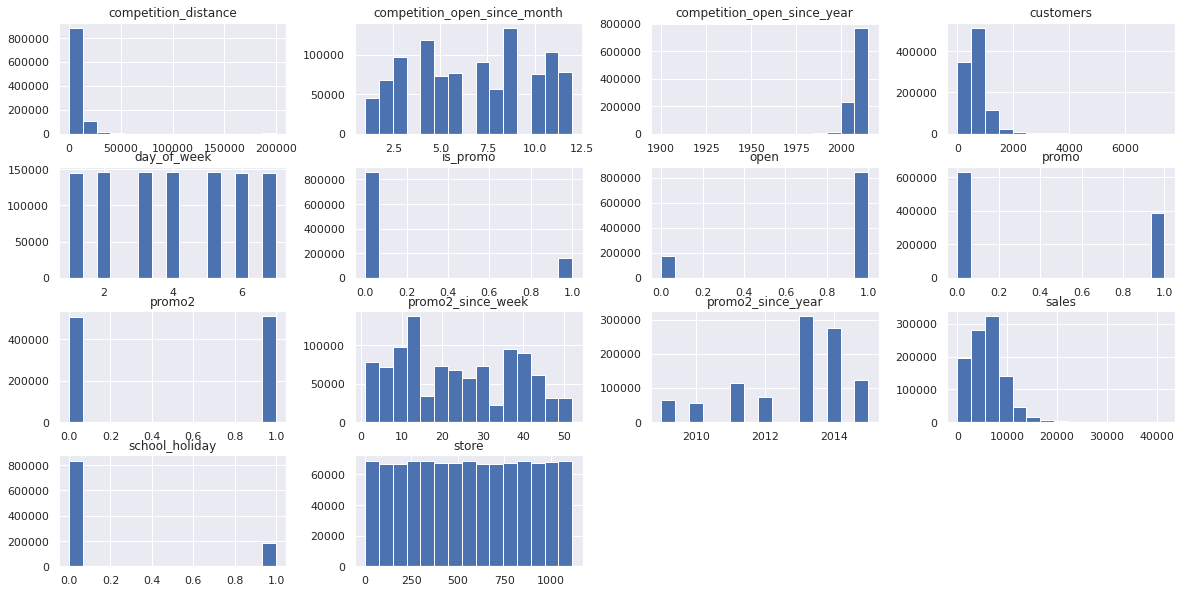

In [34]:
num_attributes.hist(bins=15);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


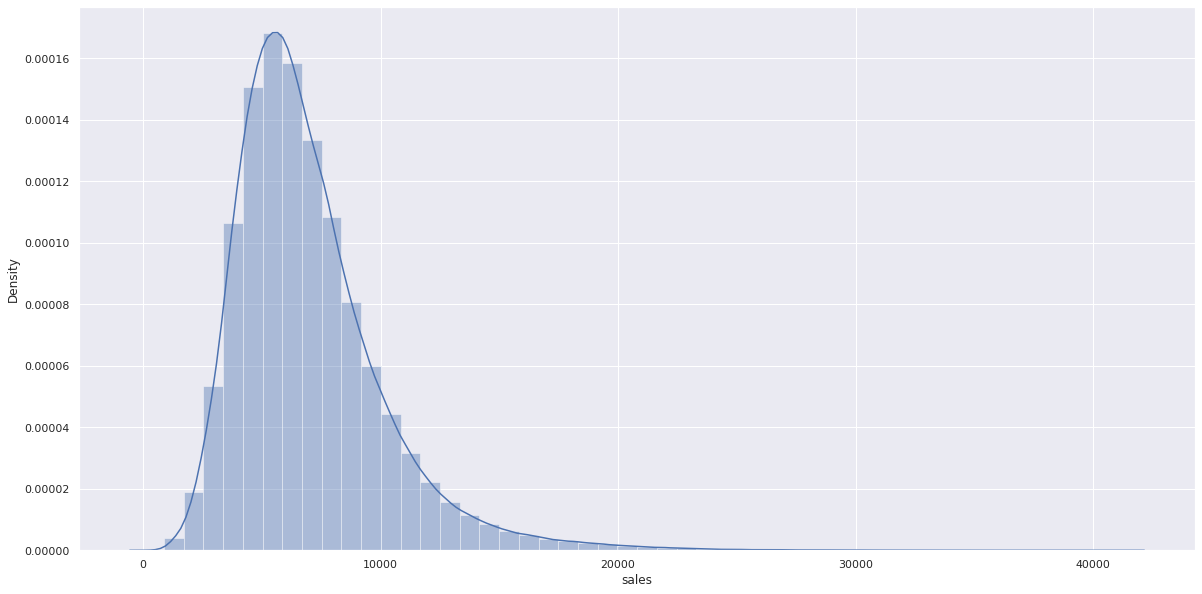

In [35]:
sns.distplot(df4['sales'], kde=True)

### 4.1.3 Categorical Variable

In [36]:
df4['state_holiday'].drop_duplicates()

0           regular_day
1243     public holiday
76852    Easter holiday
76953         Christmas
Name: state_holiday, dtype: object

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


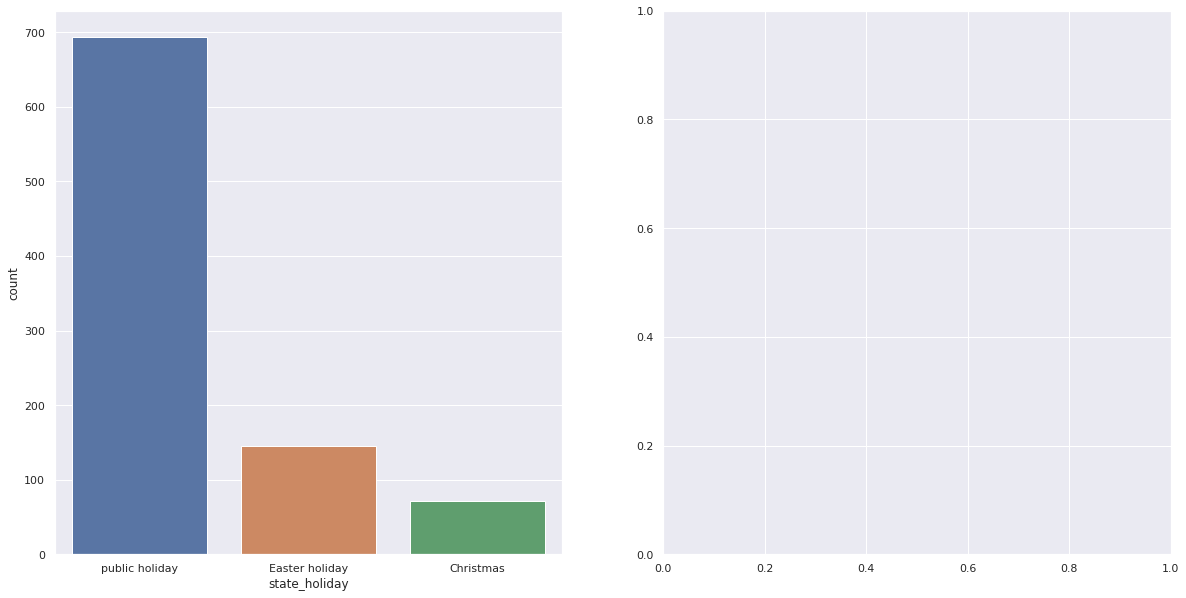

In [37]:
#state_holiday
plt.subplot(1, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
#store_type
#assortment

## 4.2 Analysis Bivariate

### 4.2.1 - Hipoteses

#### H1- Lojas com competidores mais próximos deveriam vender menos.
**False** Lojas com competidores mais próximos vendem MAIS

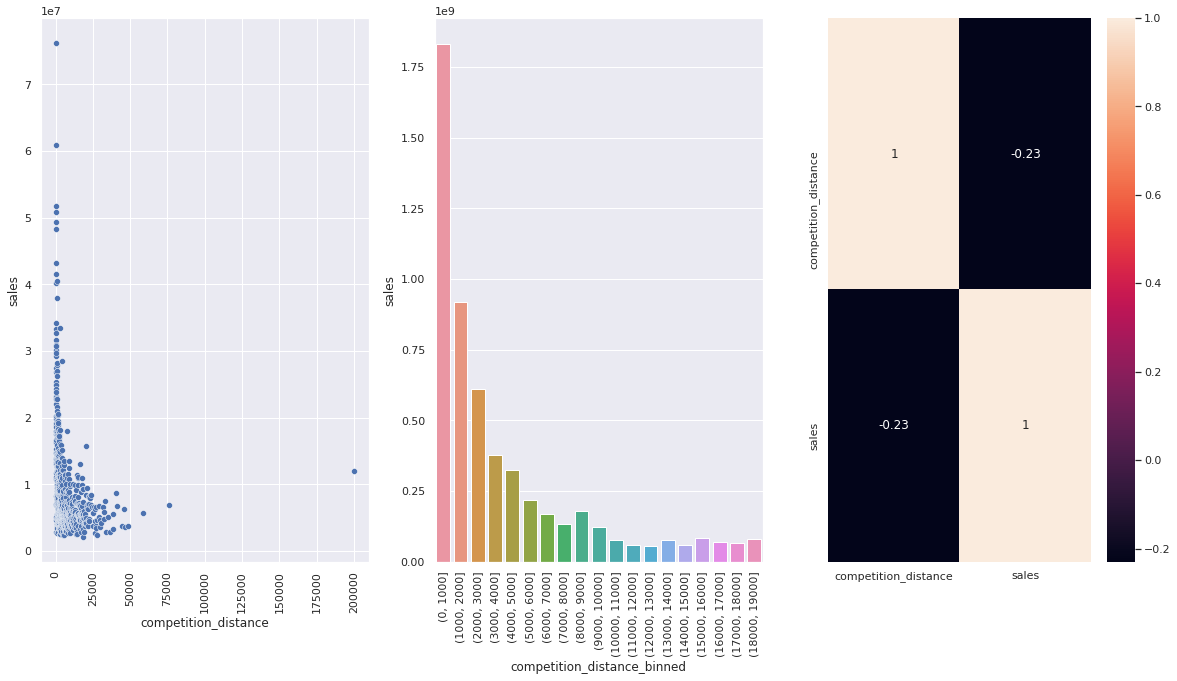

In [38]:
aux01= df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

#Plotagem de gráficos
plt.subplot(1,3,1)# Uma Linha, 3 colunas , Primeira Posição
sns.scatterplot(x='competition_distance', y='sales', data= aux01);
plt.xticks(rotation=90);

bins = list(np.arange(0,20000,1000))
aux01['competition_distance_binned'] = pd.cut(aux01['competition_distance'], bins= bins)
aux02= aux01[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2) # Uma Linha, 3 colunas , Segunda Posição
sns.barplot(x='competition_distance_binned', y='sales', data= aux02);
plt.xticks(rotation=90);

plt.subplot(1,3,3) # Uma Linha, 3 colunas , Terceira Posição

corr = sns.heatmap(aux01.corr(method='pearson'),annot=True)
#bottom, top = corr.get_ylim()
#corr.set_ylim(bottom+0.5, top-0.5)

#### H2- Lojas com maior sortimento deveriam vender mais.
**False** Lojas com maior sortimento vendem MENOS

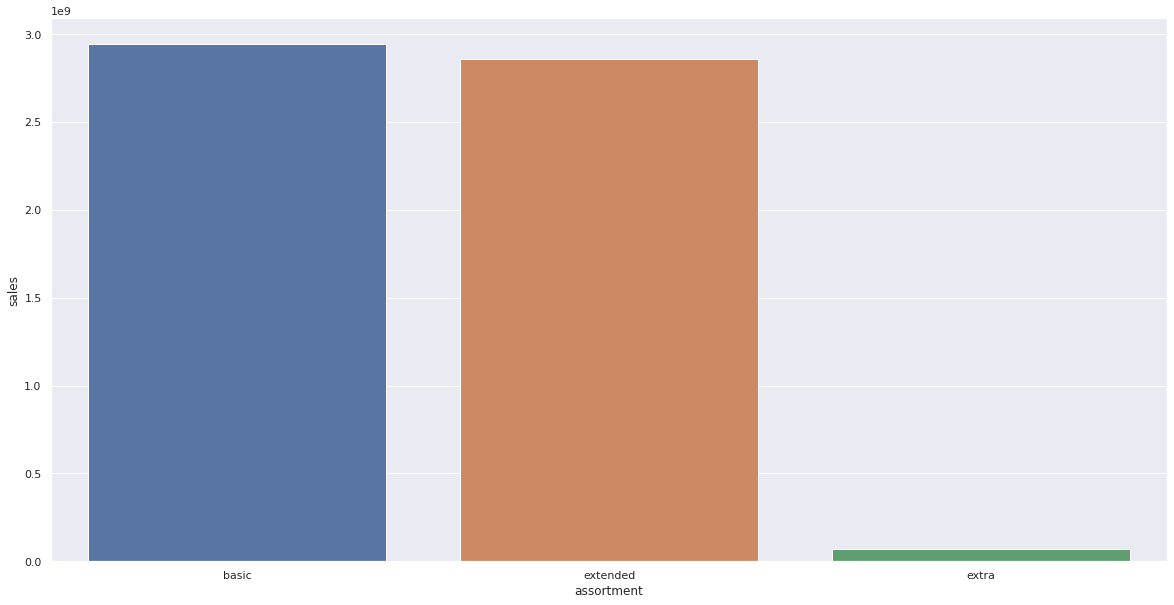

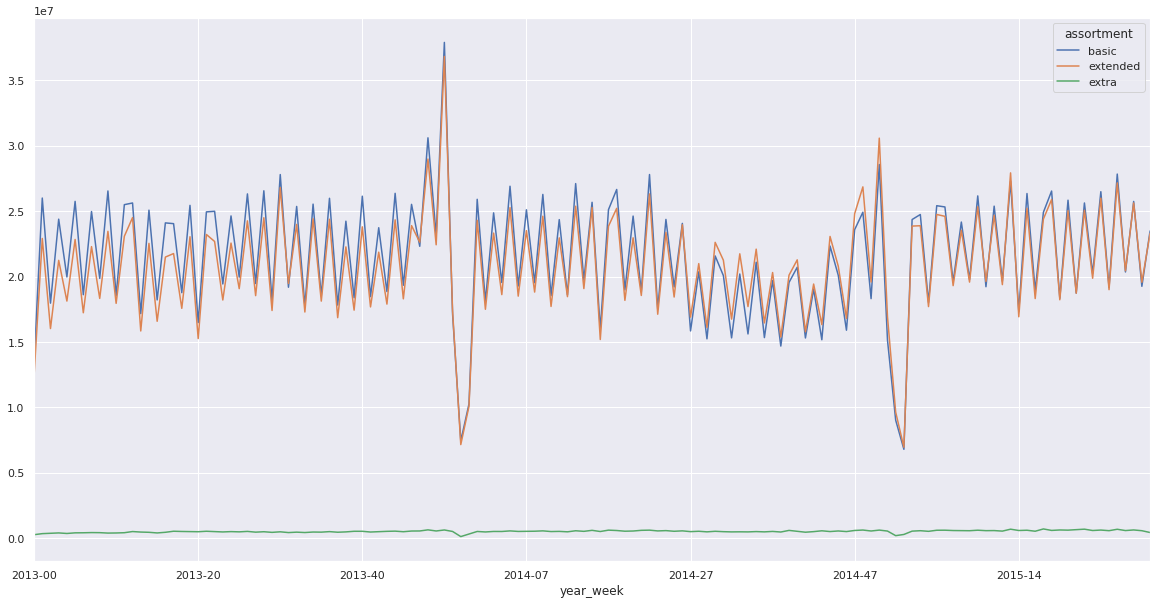

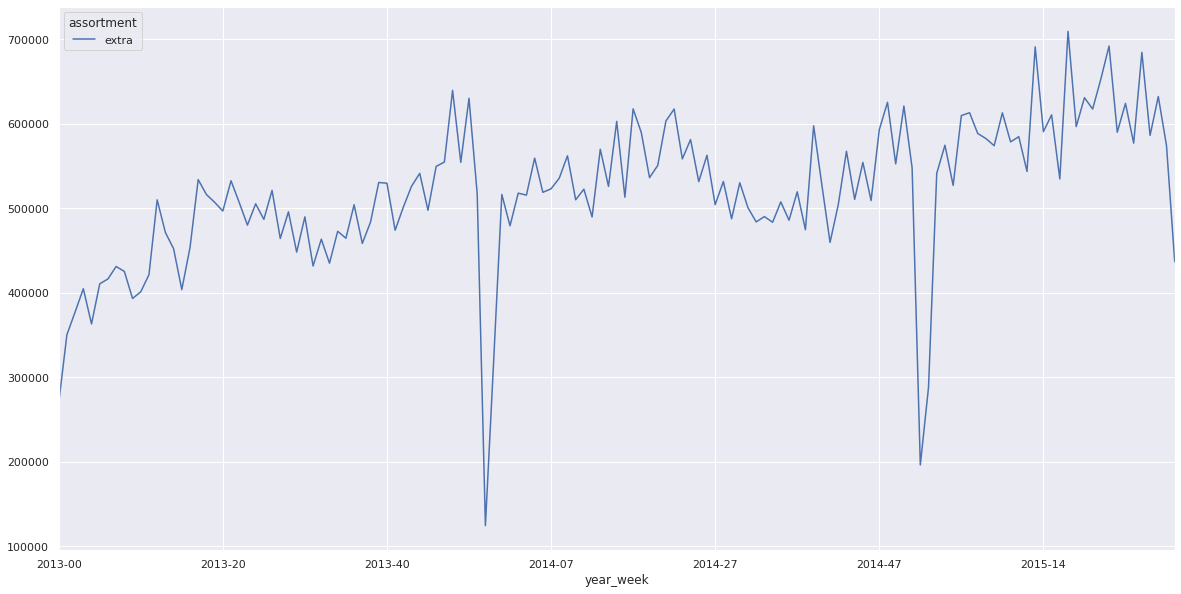

In [39]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

sns.barplot(x='assortment', y='sales', data= aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

aux2.pivot(index='year_week', columns='assortment', values='sales').plot()


aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

#### H3- Lojas com competidores à mais tempo deveriam vender mais.
**False** Lojas com competidores à mais tempo vendem MENOS

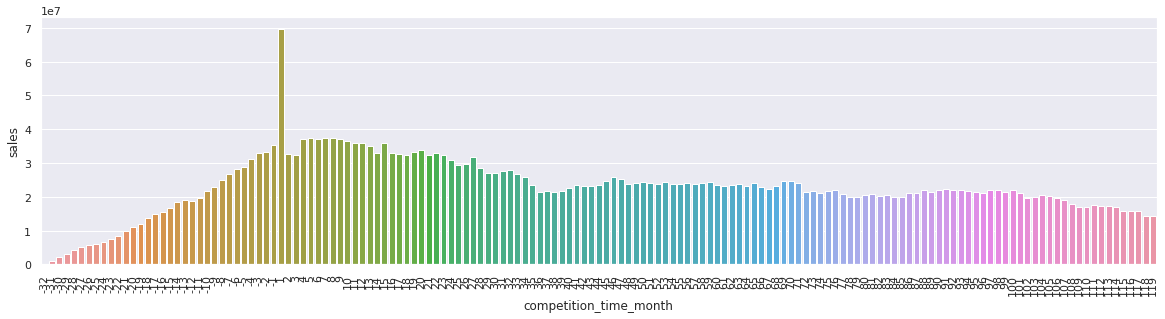

In [40]:
aux01= df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux02 = aux01[(aux01['competition_time_month'] < 120) & (aux01['competition_time_month'] != 0)]


plt.subplot(2,1,1)
sns.barplot(x='competition_time_month', y='sales', data= aux02);
plt.xticks(rotation=90);










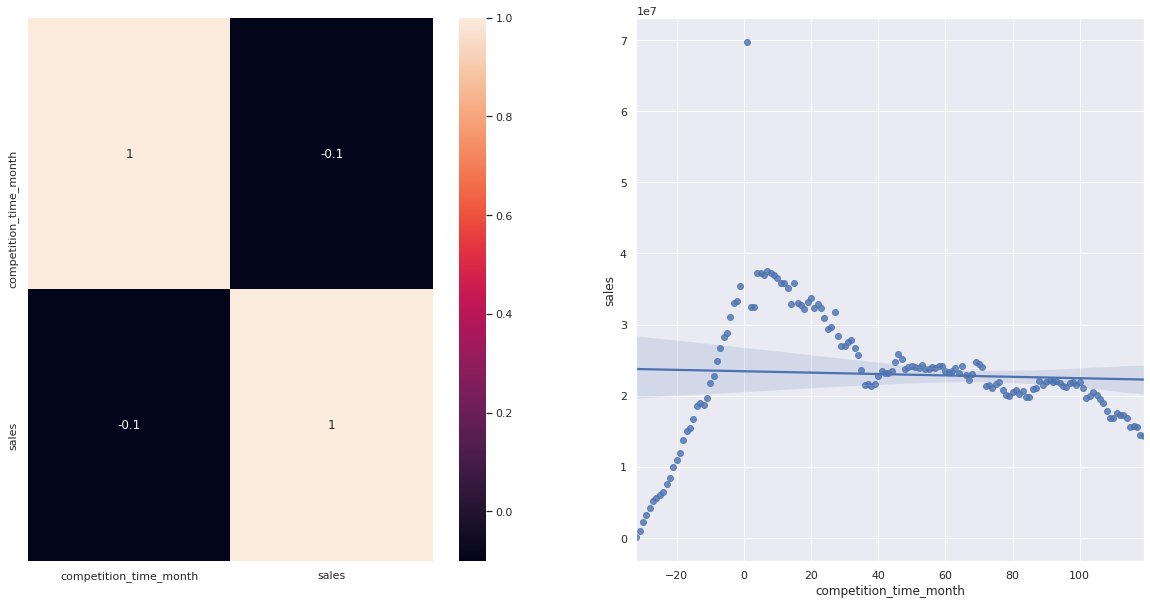

In [41]:
plt.subplot(1,2,1)
corr = sns.heatmap(aux01.corr(method='pearson'),annot=True);

plt.subplot(1,2,2)
sns.regplot(x='competition_time_month', y='sales', data= aux02);

#### H4- Lojas com promoções ativas por mais tempo deveriam vender mais.
**False** Lojas com promoções ativas por mais tempo Vendem MENOS

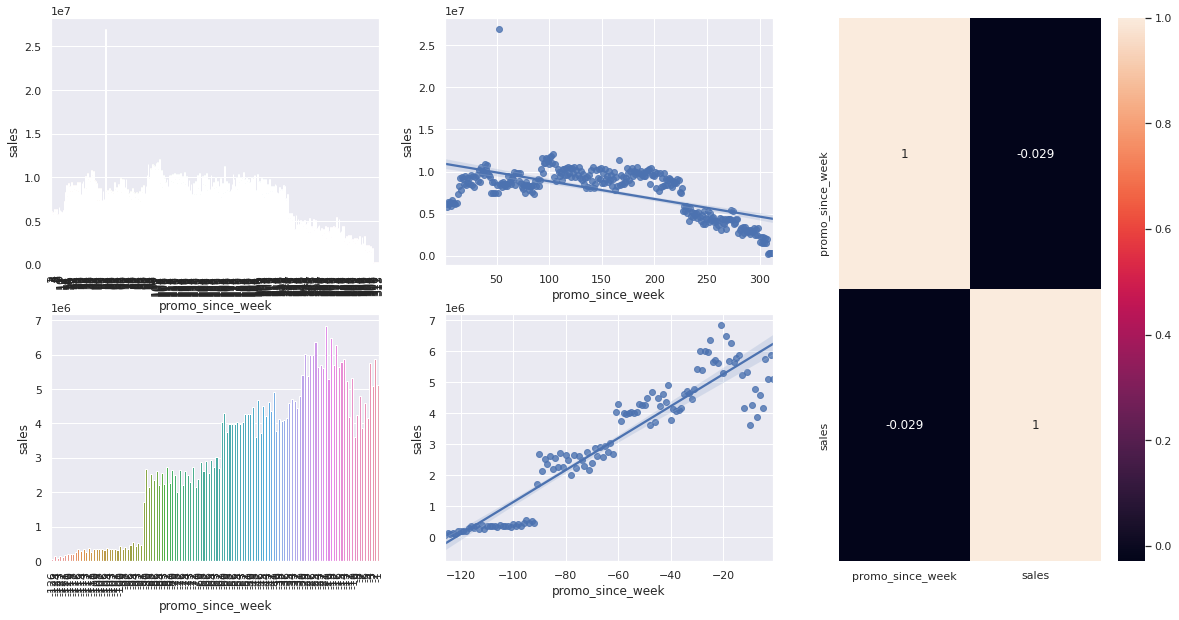

In [42]:
aux1= df4[['promo_since_week', 'sales']].groupby('promo_since_week').sum().reset_index()


grid =GridSpec(2,3)


plt.subplot(grid[ 0, 0])
aux2= aux1[aux1['promo_since_week'] > 0 ] #promo extendido
sns.barplot(x='promo_since_week', y= 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(grid[ 0, 1])
sns.regplot(x='promo_since_week', y= 'sales', data = aux2);


plt.subplot(grid[ 1, 0])
aux3= aux1[aux1['promo_since_week'] < 0 ] # promo regular
sns.barplot(x='promo_since_week', y= 'sales', data = aux3);
plt.xticks(rotation=90);

plt.subplot(grid[ 1, 1])
sns.regplot(x='promo_since_week', y= 'sales', data = aux3);

plt.subplot (grid[ :, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### <s> H5- Lojas com mais dias de promoção deveriam vender mais. </s>


#### H6- Lojas com mais promoções consecutivas deveriam vender mais.
**False** Lojas com mais promoções consecutivas vendem MENOS

In [43]:
df4[['promo', 'promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


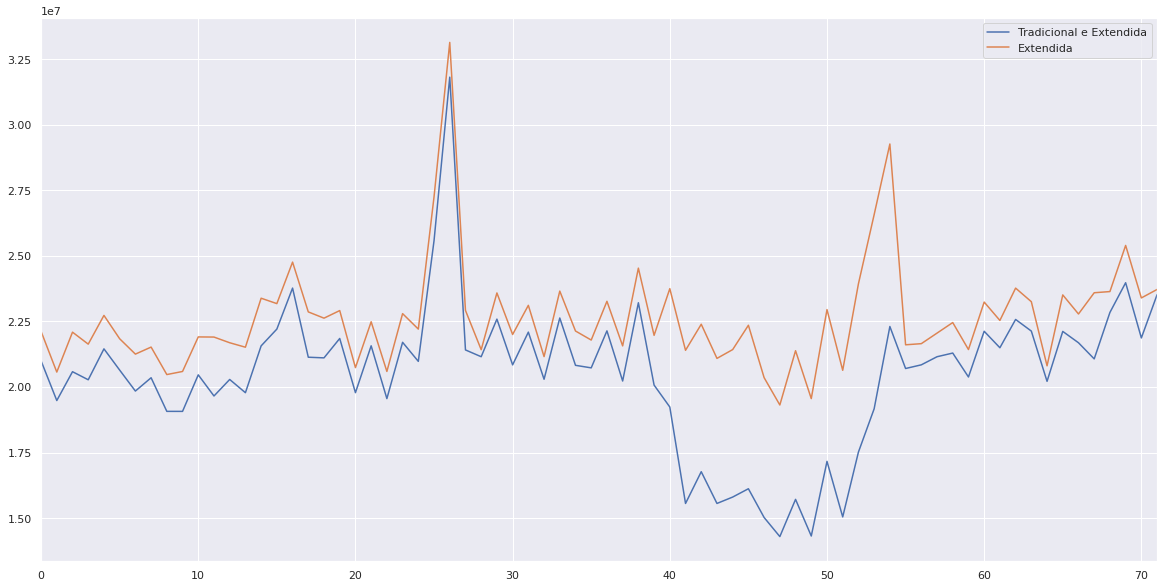

In [44]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida','Extendida'])

#### H7- Lojas abertas durante o feriado de Natal deveriam vender mais.
**False** Lojas abertas durante o feriado de Natal vendem MENOS

In [45]:
df4.head(3)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_since_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,1,4,2015-07-30,5020,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,30,31,2015-30,2008-09-01,84,2015-07-27,0
2,1,3,2015-07-29,4782,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,29,31,2015-30,2008-09-01,84,2015-07-27,0


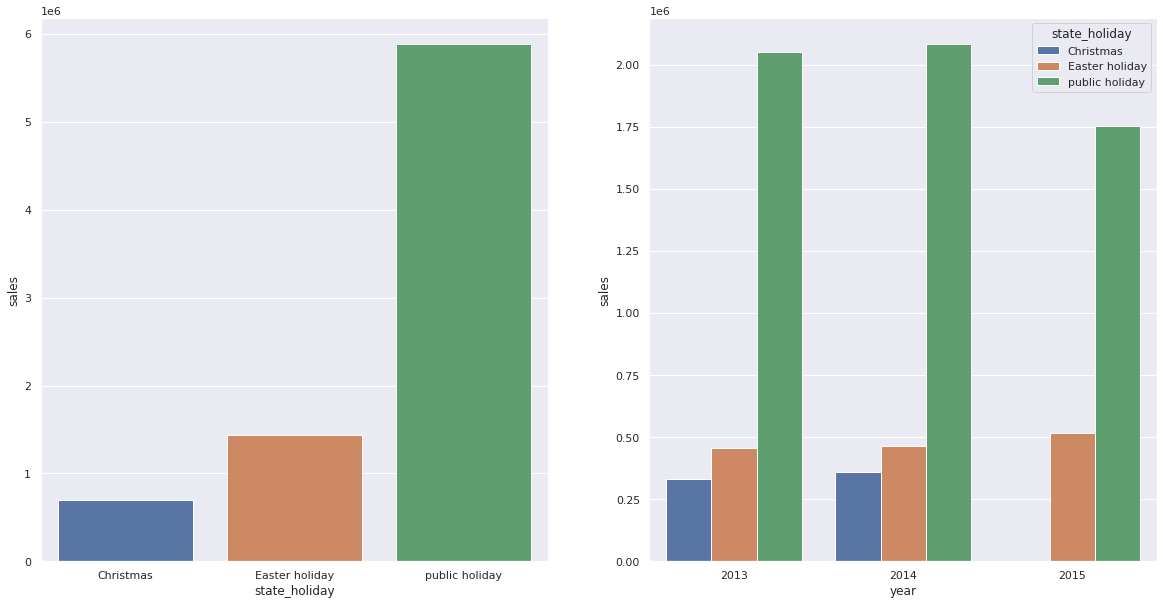

In [46]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2= aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue= 'state_holiday', data=aux2);

#### H8- Lojas deveriam vender mais ao longo dos anos
**False** Lojas vendem MENOS ao longo dos anos

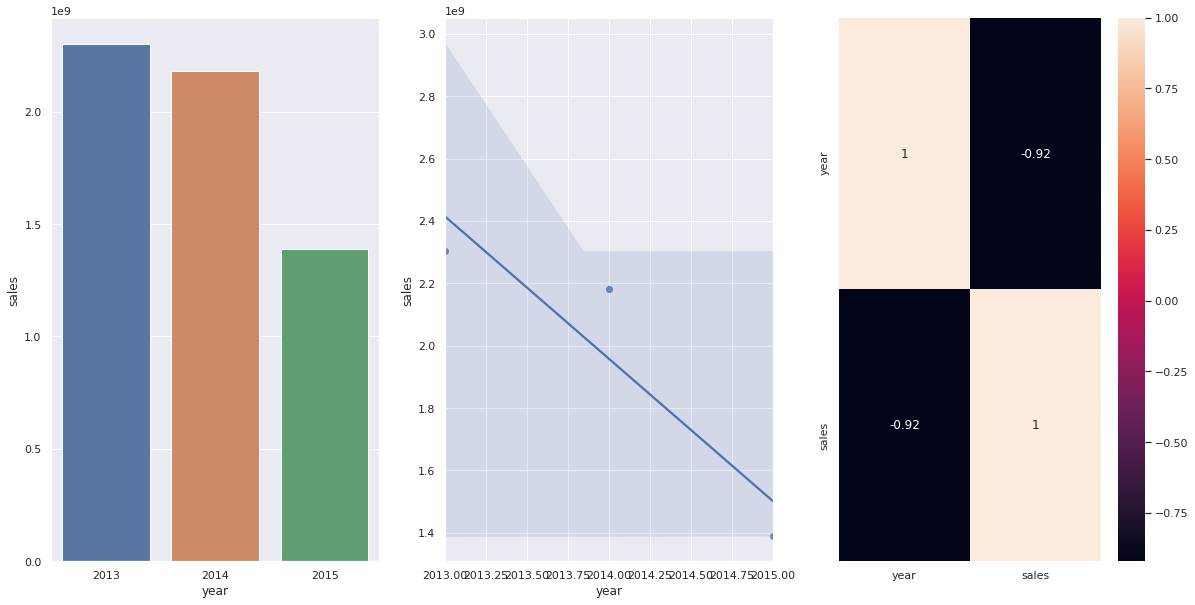

In [47]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)



#### H9- Lojas deveriam vender mais no segundo semestre do ano.
**False** Lojas vendem MENOS no segundo semestre do ano

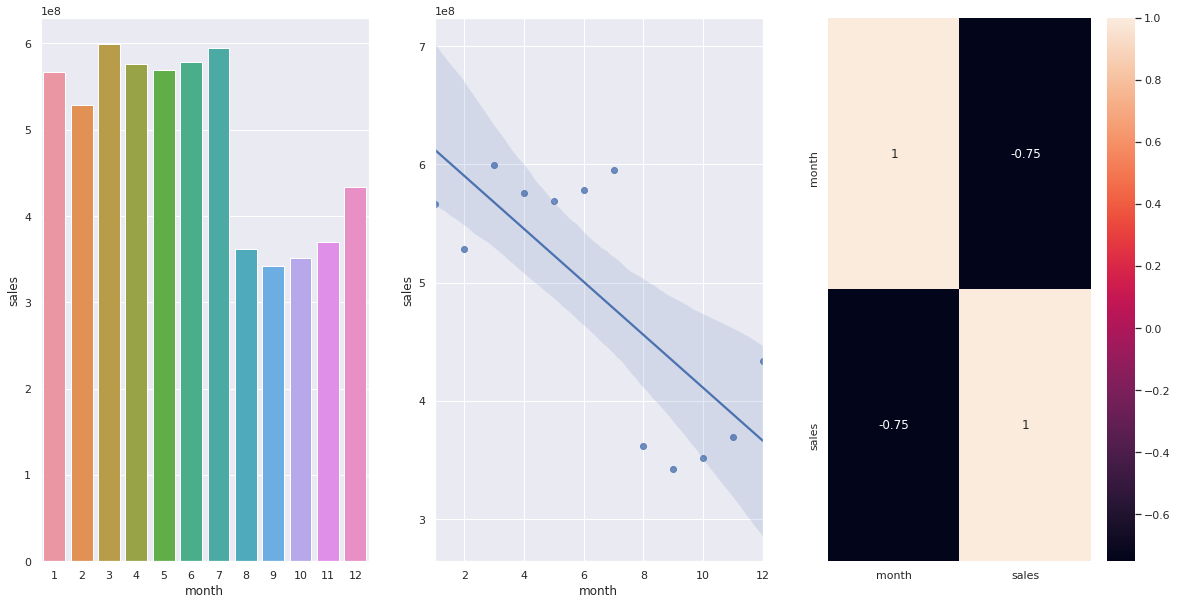

In [48]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

#### H10- Lojas deveriam vender mais depois do dia 10 de cada mês.

**True** 

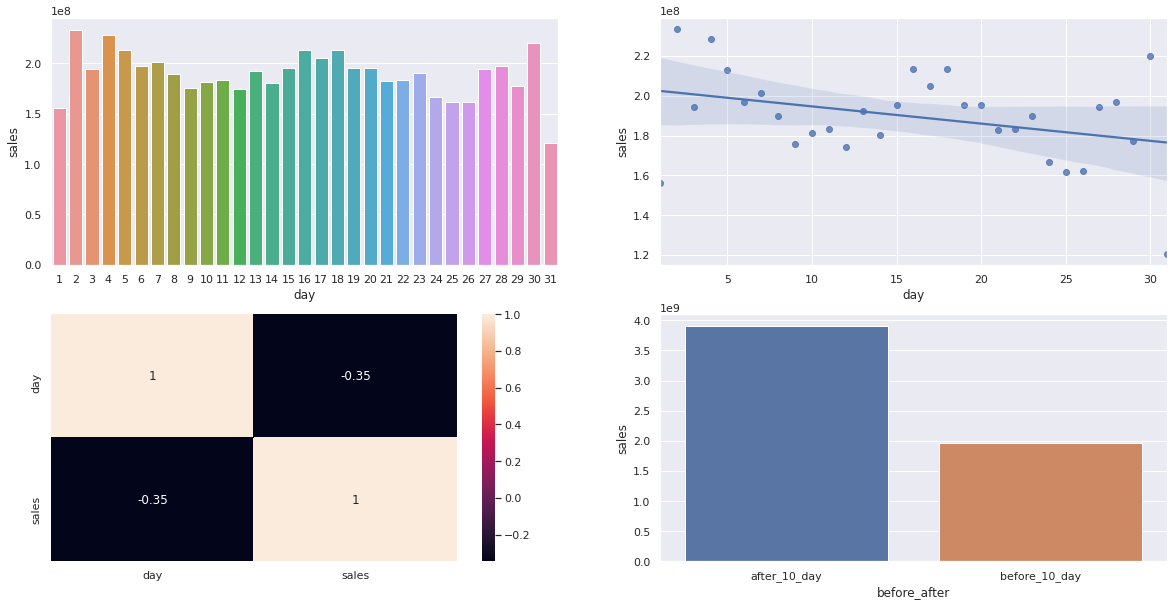

In [49]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data= aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data= aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data= aux2);

#### H11- Lojas deveriam vender menos aos finais de semana.
**True** 

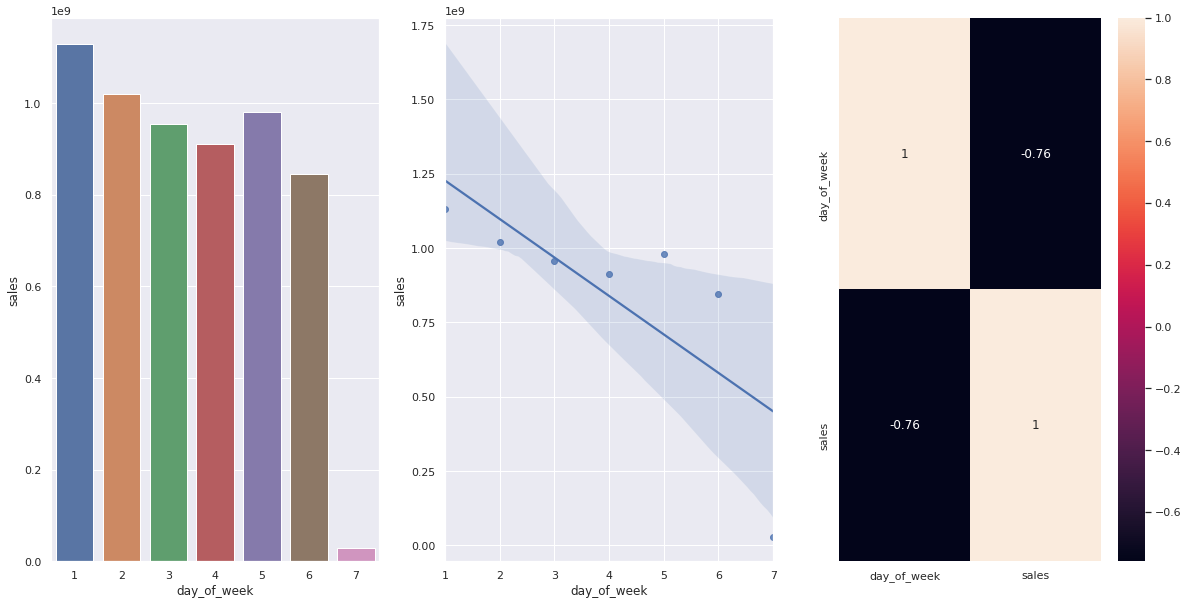

In [50]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

#### H12- Lojas deveriam vender menos durante os feriados escolares.
**TRUE** Lojas vendem menos durantes os feriados escolares exceto julho e agosto

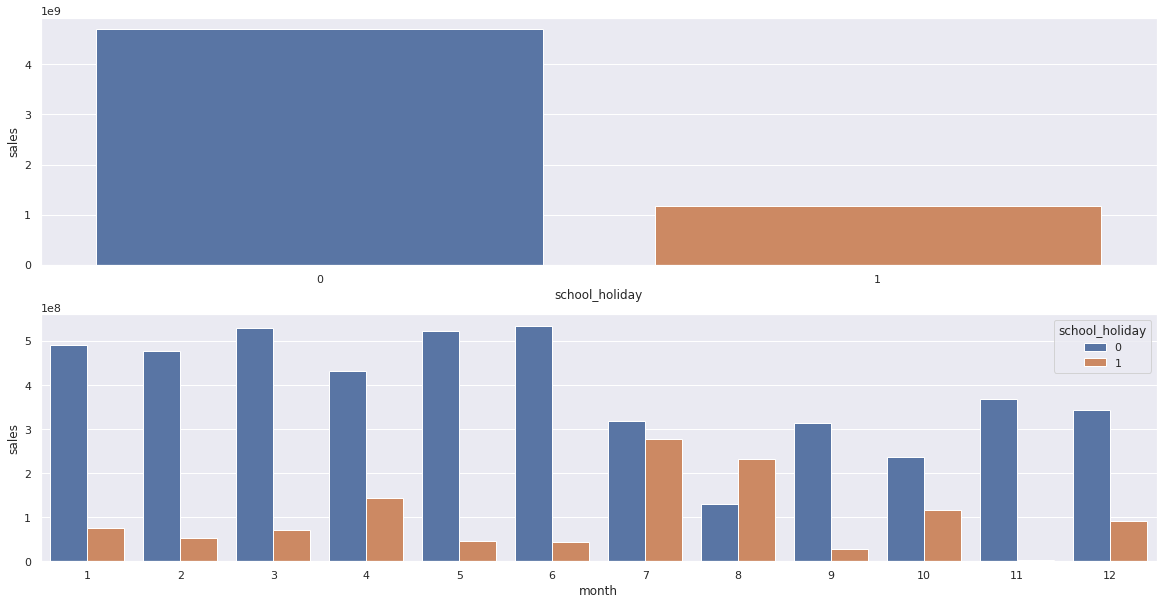

In [51]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data= aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday', data= aux2);


### 4.2.2 - Resumo das Hipoteses

In [52]:
tab =[['Hipotese', 'Conclusão','Relevância'],
       ['H1','Falsa', 'Baixa'],
       ['H2','Falsa', 'Média'],
       ['H3','Falsa', 'Média'],
       ['H4','Falsa', 'Baixa'],
       ['H5','---', '---'],
       ['H6','Falsa', 'Baixa'],
       ['H7','Falsa', 'Média'],
       ['H8','Falsa', 'Alta'], 
       ['H9','Falsa', 'Alta'], 
       ['H10','Verdadeira', 'Alta'],
       ['H11','Verdadeira', 'Alta'],
       ['H12','Verdadeira', 'Baixa'],
] 

print(tabulate(tab, headers='firstrow'))

Hipotese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Média
H3          Falsa        Média
H4          Falsa        Baixa
H5          ---          ---
H6          Falsa        Baixa
H7          Falsa        Média
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3 Analysis Multivariate


### 4.3.1 - Numerical Attributes

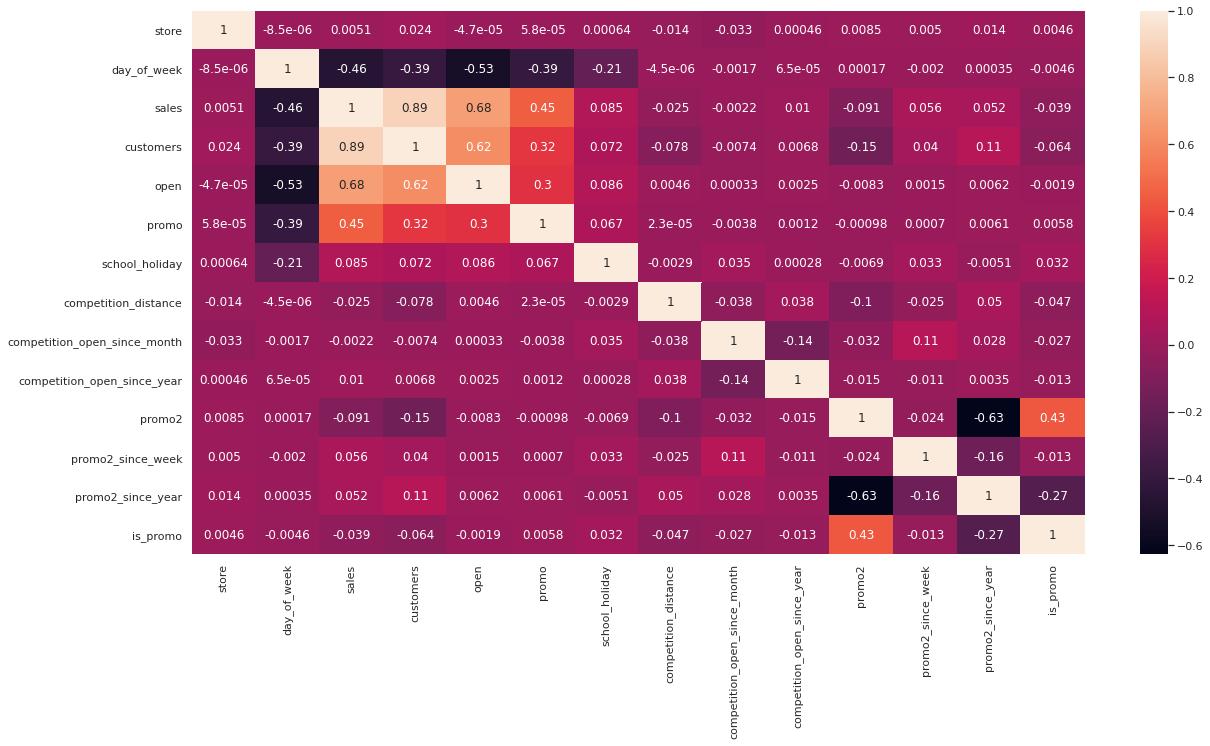

In [53]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 - Categorical Attributes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


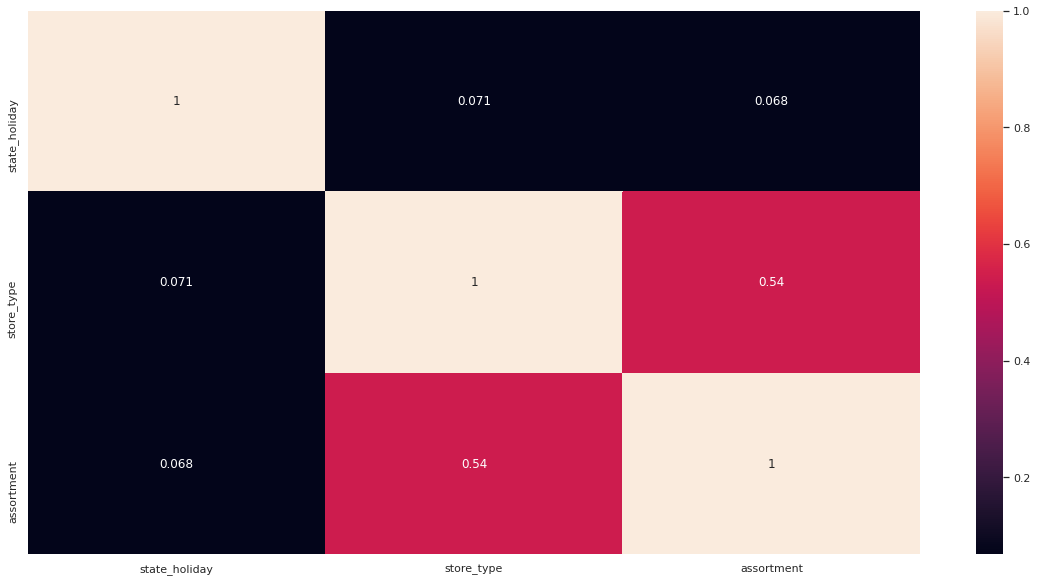

In [54]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final Dataset

data = pd.DataFrame({'state_holiday':[a1,a2,a3],
                     'store_type':[a4,a5,a6],
                     'assortment':[a7,a8,a9]})

data = data.set_index(data.columns)
sns.heatmap(data,annot=True)

# 5.0 Data Preparation

In [55]:
df5 = df4.copy()

## 5.1 Normalization

In [56]:
# Verificar váriaveis que tem uma distribuição guaussiana

## 5.2 Rescaling

In [57]:
a = df5.select_dtypes(include=['float64','int64'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

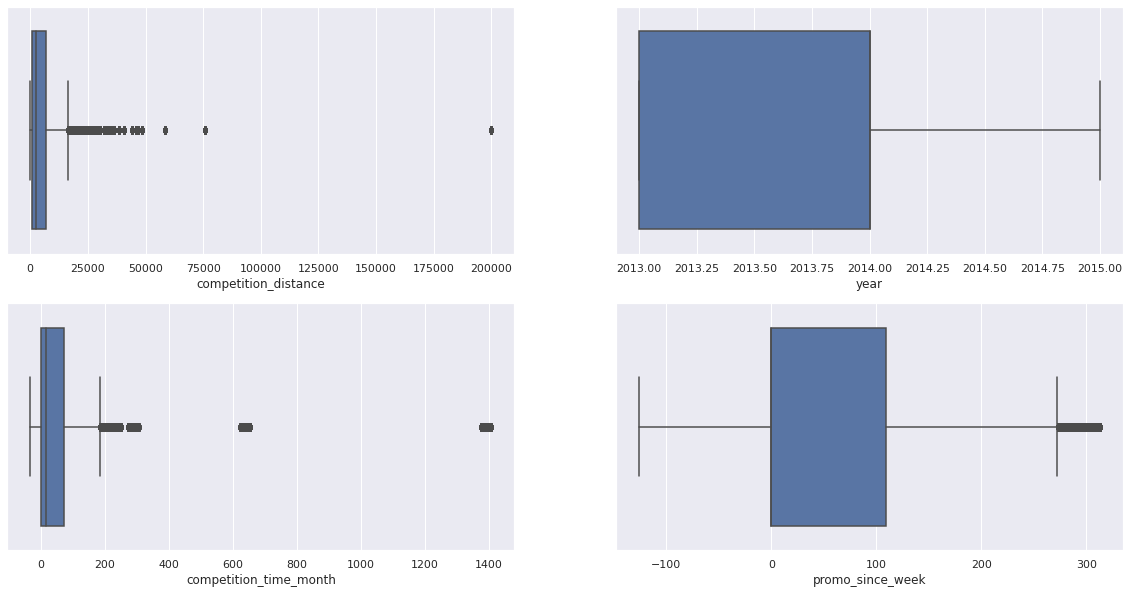

In [58]:
plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance'])

plt.subplot(2,2,2)
sns.boxplot(df5['year'])

plt.subplot(2,2,3)
sns.boxplot(df5['competition_time_month'])

plt.subplot(2,2,4)
sns.boxplot(df5['promo_since_week'])

In [59]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance (Robust)

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition_time_month (Robust)

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#year (Rescale)

df5['year'] = mms.fit_transform(df5[['year']].values)

#promo_since_week (Rescale)

df5['promo_since_week'] = mms.fit_transform(df5[['promo_since_week']].values)


## 5.3 Transformation

<b>- One hot Encoding</b>
     - Muito simples de usar e tem uma desvantagens de criar muitas colunas no seu dataset ( variaveis com muitos níveis não são muitos bons)
    
<b>- Label Encoding</b>
    - Funciona quando as variáveis tem apenas nomes ( nome de loja) - Não tem uma ordem

<b>- Ordinal Encoding</b>
    - Relação ordinal que tem uma relação de ordem 
    
<b>- Target Encoding</b>
    - Ele calcula a média e substitui o valor na variável 

<b>- Frequency Encoding</b>

<b>- Embedding Encoding</b>

### 5.3.1 Encoding

In [60]:
# state_holiday - One Hot Encoding

df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'])

# store_type Label Encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment Ordinal Encoding

assortment_dict = {'basic':1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [61]:
df5['sales']= np.log1p(df5['sales'])

### 5.3.2 Nature Transformation

In [62]:
# Variáveis ciclicas (que sempre se repetem em um determinado tempo)

#month
df5['month_sin']= df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12) ) )
df5['month_cos']= df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12) ) )

#day
df5['day_sin']= df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30) ) )
df5['day_cos']= df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30) ) )

#week_of_year
df5['week_of_year_sin']= df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52) ) )
df5['week_of_year_cos']= df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52) ) )

#day_of_week
df5['day_of_week_sin']= df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7) ) )
df5['day_of_week_cos']= df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7) ) )

# 6.0 Feature Selection

## 6.1 Split Dataframe Into Training and Test Dataset

In [63]:
cols_drop = ['day', 'month', 'week_of_year', 'day_of_week','year_week','competition_since','promo_since']
df5 = df5.drop(cols_drop, axis=1)

In [64]:
df5[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [65]:
#Training dataset
X_train = df5[df5['date'] < '2015-06-19']
y_train = X_train['sales']  

#Test dataset
X_test = df5[df5['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min date: {}'.format(X_train['date'].min()))
print('Training Max date: {}'.format(X_train['date'].max()))

print('\nTest Min date: {}'.format(X_test['date'].min()))
print('Test Max date: {}'.format(X_test['date'].max()))

Training Min date: 2013-01-01 00:00:00
Training Max date: 2015-06-18 00:00:00

Test Min date: 2015-06-19 00:00:00
Test Max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [66]:
# training and test dataset for Boruta

#X_train_n = X_train.drop(['date','sales'],axis=1).values
#y_train_n = y_train.values.ravel()

# define RandomForest Regressor

#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta

#boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_n,y_train_n)

### 6.2.1 Best Features from Boruta

In [67]:
# quando o Boruta terminar vamos usar as variáveis que ele rankiou de melhor relevância

#cols_selected= boruta.support_.tolist()

# Best features 

#X_train_fs = X_train.drop(['sales','date'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

# Not selected Boruta

#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

#Verificar as colunas selecionadas
#cols_selected_boruta 
#cols_not_selected_boruta 


### 6.3. Manual Feature Selection

In [68]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2','promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_since_week',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'day_of_week_sin', 
                        'day_of_week_cos']


# columns to add
feat_to_add = ['date','sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


# 7.0 Machine Learning

In [69]:
x_train =  X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full]

## 7.1 Average Model


In [70]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction

aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance

baseline_result = ml_error('Average Model',np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.413001,1835.135542


## 7.2 Linear Regression Model

In [71]:
from sklearn.linear_model  import LinearRegression


In [72]:
#model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.313299,0.292392,2674.576594


### 7.2.1 Linear Regression Model - Cross Validation

In [73]:
lr_result_cv = cross_validation(x_training,5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.69+/-293.36,0.3+/-0.02,2950.49+/-464.71


## 7.3 Linear Regression Regularized Model - Lasso

In [74]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1 Linear Regression Model Lasso - Cross Validation

In [75]:
lrr_result_cv = cross_validation(x_training,5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## 7.4 Random Forest Regressor

In [76]:
#model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(x_train,y_train)
#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,708.26789,0.105126,1044.319294


### 7.4.1 Random Forest Regressor - Cross Validation

In [77]:
rf_result_cv = cross_validation(x_training,5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,839.07+/-218.69,0.12+/-0.02,1257.83+/-320.83


## 7.5 XGBoost Regressor

In [78]:
#model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9).fit(x_train,y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))
xgb_result

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,847.925095,0.122826,1250.039502


### 7.5.1 XGBoost Regressor - Cross Validation

In [79]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


Kfold Number: 5


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Kfold Number: 4


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Kfold Number: 3


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Kfold Number: 2


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



Kfold Number: 1


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1048.66+/-183.98,0.14+/-0.02,1511.8+/-257.32


## 7.6 Compare Model's Performance

### 7.6.1 Single Performace

In [80]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,708.267890,0.105126,1044.319294
0,XGBoost Regressor,847.925095,0.122826,1250.039502
0,Average Model,1354.800353,0.413001,1835.135542
0,Linear Regression,1868.313299,0.292392,2674.576594
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735


### 7.6.2 Real Performace - Cross Validation

In [81]:
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.69+/-293.36,0.3+/-0.02,2950.49+/-464.71
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
0,Random Forest Regressor,839.07+/-218.69,0.12+/-0.02,1257.83+/-320.83
0,XGBoost Regressor,1048.66+/-183.98,0.14+/-0.02,1511.8+/-257.32


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Seach

In [83]:
# param = {
#          'n_estimators':[1500,1700,2500,3000,3500],
#          'eta':[0.01,0.03],
#          'max_depth':[3,5,9],
#          'subsample':[0.1,0.5,0.7],
#          'colsample_bytee':[0.3,0.7,0.9],
#          'min_child_weight':[3,8,15]
#         }
# MAX_EVAL = 5

In [84]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     #choose values for parameters randomly
#     hp = {k: random.sample(v,1)[0] for k,v in param.items()}
#     print(hp)
    
#     #model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytee=hp['colsample_bytee'],
#                                   min_child_weight = hp['min_child_weight'])


#     #performance
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#     final_result = pd.concat([final_result,result])

# final_result

## 8.2 Final Model

In [85]:
 param_tuned = {
         'n_estimators':3000,
         'eta':0.03,
         'max_depth':5,
         'subsample':0.7,
         'colsample_bytree':0.7,
         'min_child_weight':3
        }

In [86]:
#model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=param_tuned['n_estimators'],
                              eta=param_tuned['eta'],
                              max_depth=param_tuned['max_depth'],
                              subsample=param_tuned['subsample'],
                              colsample_bytree=param_tuned['colsample_bytree'],
                              min_child_weight =param_tuned['min_child_weight']).fit(x_train,y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
 
xgb_result_tuned = ml_error('XGBoost Regressor Tuned',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor Tuned,675.419295,0.099971,967.715559
